In [ ]:
import sys
!pip install git+https://gitlab.aicrowd.com/aicrowd/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic

In [4]:
%reload_ext aicrowd.magic

In [5]:
API_KEY = "906daefa5cd971fd9e089a213054d8ed"
%aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [4]:
%aicrowd dataset list -c tiring-text
%aicrowd dataset download -c tiring-text -j 3

              Datasets for challenge #748                                       
┌───┬───────────────────────┬─────────────┬───────────┐                         
│ # │ Title                 │ Description │      Size │                         
├───┼───────────────────────┼─────────────┼───────────┤                         
│ 0 │ sample_submission.csv │ -           │ 136.43 KB │                         
│ 1 │ test.csv              │ -           │  10.10 MB │                         
│ 2 │ train.csv             │ -           │  40.85 MB │                         
└───┴───────────────────────┴─────────────┴───────────┘                         


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

In [7]:
df = pd.read_csv("train.csv")
df

,text,tag
0,". CHIEF JUSTICE ROBERTS , JUSTICE PRYOR . JUST...",news
1,want this pawn like not even to exist because ...,chess
2,"? If I was n't already at that URL , where mig...",programming
3,a power is 3x squared the derivative of positi...,math
4,Knight to f2 check and the White King has no m...,chess
...,...,...
79371,to watch the live streams follow on twitch lin...,chess
79372,WHO IS HE GOING TO GET TO PROSECUTE IT ? HE BR...,news
79373,is you 're not fighting on the right side of t...,chess
79374,about the MacBook if you were n't already goin...,tech


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


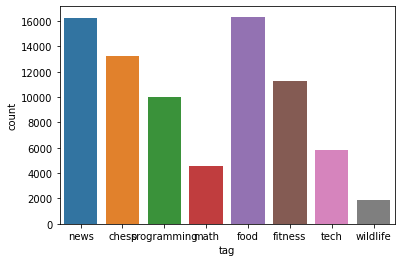

In [8]:
sns.countplot(df['tag'])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_df = pd.read_csv("train.csv")
X = train_df["text"]

le = LabelEncoder()
Y = le.fit_transform(train_df["tag"])

X_train, X_test ,Y_train, Y_test = train_test_split(X, Y, test_size=0.01)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(78582,)
(78582,)
(794,)
(794,)


In [10]:
from keras.utils import to_categorical

Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

print(Y_train_cat.shape)
print(Y_test_cat.shape)

(78582, 8)
(794, 8)


In [11]:
# TL Model
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense


model = Sequential()

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed_size=512
trainable = True
hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

model.add(hub_layer)
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(8, activation="softmax"))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name="accuracy")])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

In [12]:
epochs=6
batch_size=128

hist = model.fit(X_train, Y_train_cat,
          epochs=epochs, batch_size=batch_size,
          validation_data = (X_test, Y_test_cat),
          verbose=1)

Epoch 1/6
614/614 [==============================] - 526s 774ms/step - loss: 0.4052 - accuracy: 0.9046 - val_loss: 0.0318 - val_accuracy: 0.9951
Epoch 2/6
614/614 [==============================] - 471s 767ms/step - loss: 0.0734 - accuracy: 0.9879 - val_loss: 0.0163 - val_accuracy: 0.9954
Epoch 3/6
614/614 [==============================] - 471s 766ms/step - loss: 0.0340 - accuracy: 0.9949 - val_loss: 0.0164 - val_accuracy: 0.9953
Epoch 4/6
 53/614 [=>............................] - ETA: 7:10 - loss: 0.0199 - accuracy: 0.9972

╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 │
│ in run_code                                                                  │
│                                                                              │
│   2879 │   │   │   try:                                                      │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                        │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg         │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)     │
│   2883 │   │   │   finally:                                                  │
│   2884 │   │   │   │   # Reset our crash handler in place                    │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                       │
│ <ipython-input-12-caacbf30105c>:7 in <module>                                │
│                           

In [13]:
model.evaluate(X_test, Y_test_cat)

25/25 [==============================] - 2s 84ms/step - loss: 0.0171 - accuracy: 0.9964


[0.017062341794371605, 0.9963790774345398]

In [ ]:
hist

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

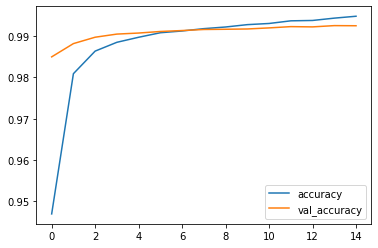

In [ ]:
metrics[["accuracy","val_accuracy"]].plot()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_classes(X_train)
print(classification_report(Y_train, predictions))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13202
           1       1.00      1.00      1.00     11245
           2       1.00      1.00      1.00     16337
           3       0.99      0.99      0.99      4560
           4       1.00      1.00      1.00     16216
           5       1.00      0.99      0.99     10038
           6       0.99      0.99      0.99      5859
           7       0.98      1.00      0.99      1911

    accuracy                           1.00     79368
   macro avg       0.99      1.00      0.99     79368
weighted avg       1.00      1.00      1.00     79368



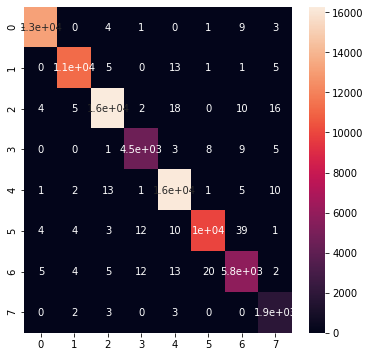

In [ ]:
plt.figure(figsize=(6,6))
mat = confusion_matrix(Y_train, predictions)
sns.heatmap(mat, annot=True)
plt.show()

In [19]:
sub_df = pd.read_csv("test.csv")

X_sub = sub_df["text"]
Y_sub = model.predict_classes(X_sub)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [20]:
sub = le.inverse_transform(Y_sub)
submission = pd.DataFrame()
submission["tag"] = sub
submission.to_csv("tiring_submission_ft2.csv")

In [21]:
submission.to_csv('submission.csv', index=False)

In [22]:
%aicrowd submission create -c tiring-text -f submission.csv

Output()

                                       ╭─────────────────────────╮                                       
                                       │ Successfully submitted! │                                       
                                       ╰─────────────────────────╯                                       
                                             Important links                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ml-battleground/submissions/124444              │
│                  │                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/ml-battleground/submissions?my_submissions=true │
│                  │                                                                                    │
│      Leaderboard │ https://www.aicrowd.com/c